In [98]:
import os
import SimpleITK as sitk
import numpy as np
import radiomics
import matplotlib.pyplot as plt
from skimage import io as skio
from skimage.color import rgb2gray
import cv2
import pandas as pd
from skimage import img_as_ubyte
import seaborn as sns

In [99]:
from radiomics import featureextractor, getFeatureClasses
from radiomics import glcm

In [100]:
cwd = os.getcwd()

In [101]:
im = skio.imread('textured-triangle.png')
im = rgb2gray(im)
im = img_as_ubyte(im)

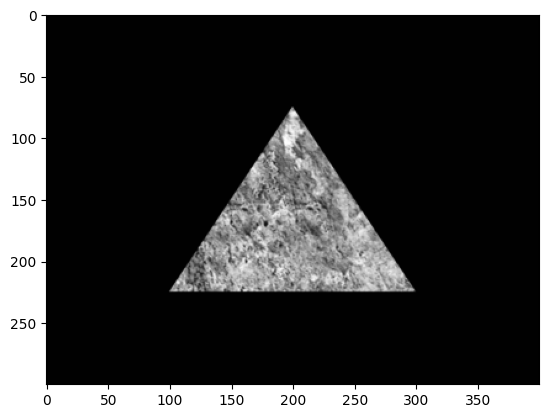

In [102]:
plt.imshow(im, cmap="gray")

In [103]:
#croping image:
n, p = im.shape

# Si la hauteur est plus grande que la largeur, recadrez en carré
if n > p:
    diff = (n - p) // 2
    im = im[diff:diff + p, :]
# Si la largeur est plus grande que la hauteur, recadrez en carré
elif p > n:
    diff = (p - n) // 2
    im = im[:, diff:diff + n]

# Maintenant, im est une image carrée
n, p = im.shape
n,  p

(300, 300)

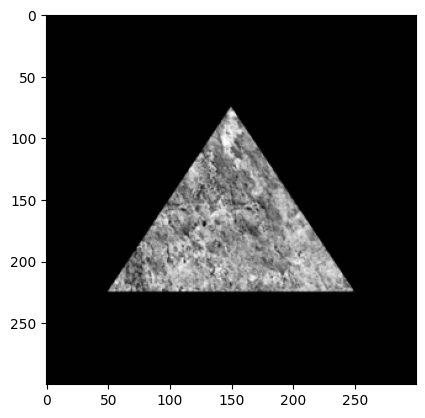

In [104]:
plt.imshow(im, cmap='gray')

In [105]:
#creation du mask

def mask(h, l, side_length):
    image = np.zeros((h, l), dtype=np.uint8)
    half_side = side_length / 2
    x1 = int((l - side_length) / 2)
    x2 = int((l + side_length) / 2)
    y1 = int((h + (side_length * np.sqrt(3) / 2)) / 2)
    y2 = int((h + (side_length * np.sqrt(3) / 2)) / 2 - side_length * np.sqrt(3) / 2)

    pts = np.array([[x1, y1], [x2, y1], [l // 2, y2]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image, [pts], 1)

    return image

Text(0.5, 1.0, 'mask')

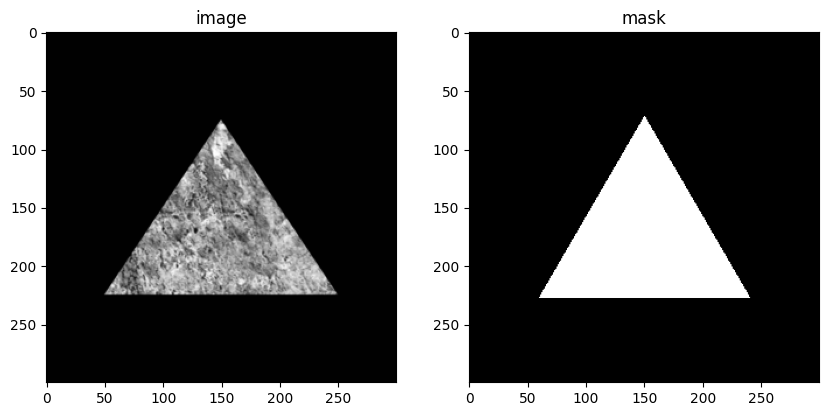

In [106]:
plt.figure(figsize=(10,10))
# First image
plt.subplot(2,2,1)
plt.imshow(im, cmap = 'gray')
plt.title("image")
plt.subplot(2,2,2)
plt.imshow(mask(300, 300, 180), cmap = 'gray')
plt.title("mask")

In [107]:
# Transform image and mask to format
im_ITK, mask_ITK  = sitk.GetImageFromArray(im), sitk.GetImageFromArray(mask(300, 300, 180))

In [108]:
extractor=featureextractor.RadiomicsFeatureExtractor()
extractor.enableFeaturesByName()

In [109]:
featuresVector = extractor.execute(im_ITK, mask_ITK)
numeric_features = {}

# Liste des noms de caractéristiques (clefs du dictionnaire) à partir de l'indice 24
feature_names = list(featuresVector.keys())[24:]

# Itérez à travers la liste des noms de caractéristiques
for feature_name in feature_names:
    feature_value = featuresVector[feature_name]
    numeric_features[feature_name] = feature_value


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [110]:
#compute only GLCM features
# la matrice de co-occurrence des niveaux de gris (GLCM)
glcmFeatures = glcm.RadiomicsGLCM(im_ITK, mask_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [111]:
features = np.array(list(result.values()))
args = list(result.keys())

In [112]:
args

['Autocorrelation',
 'ClusterProminence',
 'ClusterShade',
 'ClusterTendency',
 'Contrast',
 'Correlation',
 'DifferenceAverage',
 'DifferenceEntropy',
 'DifferenceVariance',
 'Id',
 'Idm',
 'Idmn',
 'Idn',
 'Imc1',
 'Imc2',
 'InverseVariance',
 'JointAverage',
 'JointEnergy',
 'JointEntropy',
 'MCC',
 'MaximumProbability',
 'SumAverage',
 'SumEntropy',
 'SumSquares']

In [113]:
df=pd.DataFrame({"feature":args, "value": features})

In [114]:
df

,feature,value
0,Autocorrelation,20.712846
1,ClusterProminence,99.002797
2,ClusterShade,-8.457622
3,ClusterTendency,4.765176
4,Contrast,0.734853
5,Correlation,0.731905
6,DifferenceAverage,0.536619
7,DifferenceEntropy,1.295382
8,DifferenceVariance,0.441218
9,Id,0.758738


In [115]:
#Elementary transformations :
def rotate_image(image, theta):
    # Get the center of the image
    height, width = image.shape[:2]
    center = (width / 2, height / 2)

    # Define a rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, theta, 1.0)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

In [116]:
#To facilitate, we will define a function that returns the dataframe of the GLCMfeatures of an image and mask passed in argument 

def glcmFeatures(image, mask):
    im_ITK, mask_ITK  = sitk.GetImageFromArray(image), sitk.GetImageFromArray(mask)
    glcmFeatures = glcm.RadiomicsGLCM(im_ITK, mask_ITK)
    glcmFeatures.enableAllFeatures()
    result = glcmFeatures.execute()

    features = np.array(list(result.values()))
    args = list(result.keys())
    df=pd.DataFrame({"feature":args, "value": features})
    return df


In [129]:


# List of DataFrames, one for each rotation angle
dataframes = []  
for theta in range(360):
    df_theta = glcmFeatures(rotate_image(im, theta), rotate_image(mask(300, 300, 180), theta))
    dataframes.append(df_theta)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

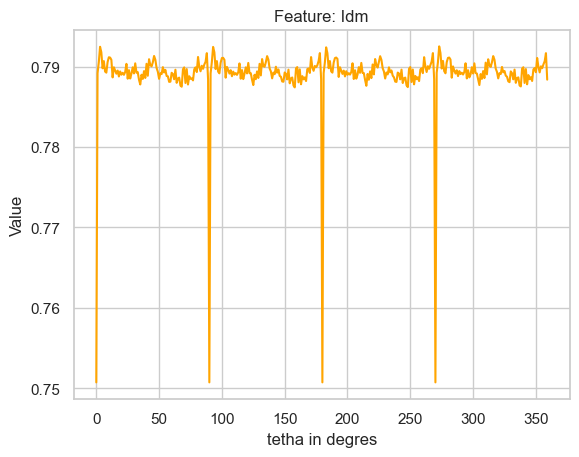

In [183]:
def plot_feature(featurew, dataframes):
    feature_values = [df[dataframes[0].feature==featurew].value.iloc[0] for df in dataframes]
    
    plt.plot(range(360), feature_values, color="orange")
    plt.title(f'Feature: {featurew}')
    plt.xlabel('tetha in degres')
    plt.ylabel('Value')

plot_feature("Idm", dataframes=dataframes)

In [159]:
dataframes[0][dataframes[0].feature=="Idm"].value.iloc[0]

0.7507300840762605

In [190]:
def plot_features(dataframes, features, figure_size=(5, 3)):
    num_features = len(features)
    num_dataframes = len(dataframes)

    fig, axes = plt.subplots(num_features, 1, figsize=(figure_size[0], figure_size[1] * num_features))

    for i, featurew in enumerate(features):
        ax = axes[i]
        feature_values = [df[dataframes[0].feature==featurew].value.iloc[0] for df in dataframes]
    
        ax.plot(range(num_dataframes), feature_values, color="blue")
        ax.set_title(f'Feature:' + featurew)
        ax.set_xlabel('tetha in degres')
        ax.set_ylabel('Value')
    plt.tight_layout()
    plt.show()

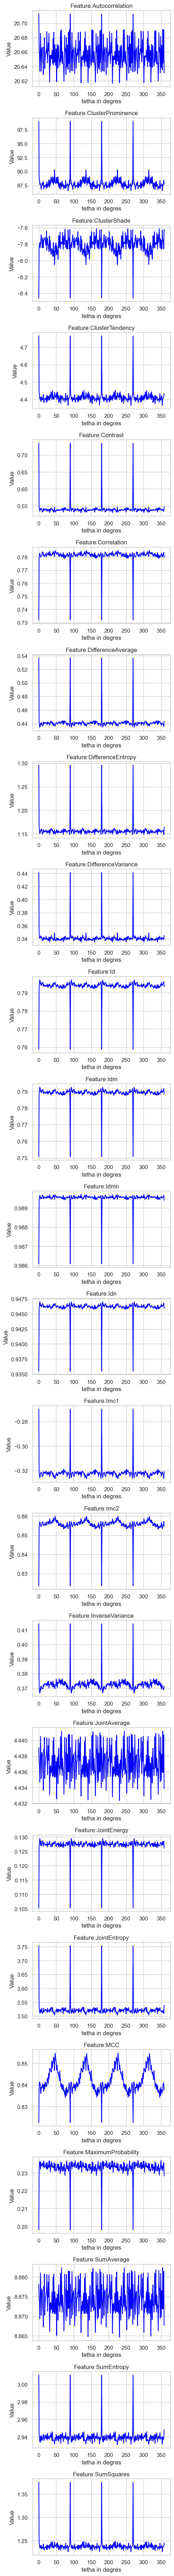

In [191]:
features_all = dataframes[0].feature.tolist()
plot_features(dataframes=dataframes, features=features_all)